<a href="https://colab.research.google.com/github/Tournesol1008/Predict-Future-Sales-Kaggle-Project/blob/main/Predict_Future_Sales_Kaggle_competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We are aim to **predict total sales for every product and store in the next month.** By solving this competition you will be able to apply and enhance your data science skills.

Dataset contains 6 CSV files:
1. test.csv: shop ID and item ID, 214200 records. You need to forecast the sales for these shops and products for **November 2015**
2. shops.csv: shop name (in Russian) and shop ID, 60 records
3. sales_train.csv: date, date block number (a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33), shop id, item id, item price, item count day (number of products sold. You are predicting a monthly amount of this measure), ~3M records
4. items.csv: item name (in Russian), item ID, item category ID, 22170 records
5. item category.cv: item category name (in Russian), item category id, 85 records
6. sample submission.csv


In [ ]:
!pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c competitive-data-science-predict-future-sales #download dataset from kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/368k [00:00<?, ?B/s]
100% 368k/368k [00:00<00:00, 55.8MB/s]
  0% 0.00/2.91k [00:00<?, ?B/s]
100% 2.91k/2.91k [00:00<00:00, 2.92MB/s]
  0% 0.00/468k [00:00<?, ?B/s]
100% 468k/468k [00:00<00:00, 64.4MB/s]
  0% 0.00/3.49k [00:00<?, ?B/s]
100% 3.49k/3.49k [00:00<00:00, 3.07MB/s]
  0% 0.00/1.02M [00:00<?, ?B/s]
100% 1.02M/1.02M [00:00<00:00, 68.0MB/s]
 68% 9.00M/13.3M [00:00<00:00, 17.5MB/s]
100% 13.3M/13.3M [00:00<00:00, 24.6MB/s]


In [ ]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x:format(x,'f'))
import seaborn as sns
from time import strptime
from matplotlib import pyplot as plt
import graphviz
import pydot
from io import StringIO  

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report, roc_curve, auc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
shops=pd.read_csv("/content/shops.csv")
items = pd.read_csv("/content/items.csv.zip")
train = pd.read_csv("/content/sales_train.csv.zip")
test = pd.read_csv("/content/test.csv.zip")
sample = pd.read_csv("/content/sample_submission.csv.zip")
item_cat = pd.read_csv("/content/item_categories.csv")

In [ ]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.000000,1.000000
1,03.01.2013,0,25,2552,899.000000,1.000000
2,05.01.2013,0,25,2552,899.000000,-1.000000
3,06.01.2013,0,25,2554,1709.050000,1.000000
4,15.01.2013,0,25,2555,1099.000000,1.000000
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.000000,1.000000
2935845,09.10.2015,33,25,7460,299.000000,1.000000
2935846,14.10.2015,33,25,7459,349.000000,1.000000
2935847,22.10.2015,33,25,7440,299.000000,1.000000


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [ ]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [ ]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849.000000,2935849.000000,2935849.000000,2935849.000000,2935849.000000
mean,14.569911,33.001728,10197.227057,890.853233,1.242641
std,9.422988,16.226973,6324.297354,1729.799631,2.618834
min,0.000000,0.000000,0.000000,-1.000000,-22.000000
25%,7.000000,22.000000,4476.000000,249.000000,1.000000
50%,14.000000,31.000000,9343.000000,399.000000,1.000000
75%,23.000000,47.000000,15684.000000,999.000000,1.000000
max,33.000000,59.000000,22169.000000,307980.000000,2169.000000


Two findings:
(1) Both the price and sales have some negative numbers, which we should think about whether to remove or not. Considering that there are not many negative values and negative values can hurt multiplicative seasonality diagnostics, we should delete negative values.
(2) Sales for at least 75% of records are only 1. Negative may represents returned items. If they are returned items, then it is better to set them to zero. Because no item was sold on that date and that returned item is included in previous sales. There are 2935849 rows in train data, among them 7536 rows or 0.00256% are negative value of item_cnt_day. Maybe they are outliers needed dropped.

# Data Preprocessing

In [ ]:
#transfer date to date format
from datetime import datetime
  
def timestamp(x):
    return datetime.strptime(x, "%d.%m.%Y")

In [ ]:
train['date'] = train['date'].apply(timestamp)

In [ ]:
# Print rows with negative values in price and sales
print(train.loc[train['item_price'] <= 0])
print(train.loc[train['item_cnt_day'] < 0])

             date  date_block_num  shop_id  item_id  item_price  item_cnt_day
484683 2013-05-15               4       32     2973   -1.000000      1.000000
              date  date_block_num  shop_id  item_id  item_price  item_cnt_day
2       2013-01-05               0       25     2552  899.000000     -1.000000
148     2013-01-23               0       25     2321  999.000000     -1.000000
175     2013-01-07               0       25     2199 1449.000000     -1.000000
807     2013-01-02               0       25     2330  599.000000     -1.000000
1041    2013-01-13               0       25     5034 1989.000000     -1.000000
...            ...             ...      ...      ...         ...           ...
2934243 2015-10-26              33       25     3917  449.000000     -1.000000
2934462 2015-10-18              33       25     4896 6398.000000     -1.000000
2935263 2015-10-05              33       25    10039  249.000000     -1.000000
2935643 2015-10-16              33       25     7893 2

In [ ]:
# Remove rows containing negative sales and price
train=train[train.select_dtypes(include=[np.number]).ge(0).all(1)]
train.shape


(2928492, 6)

In [ ]:
# Check NA
train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

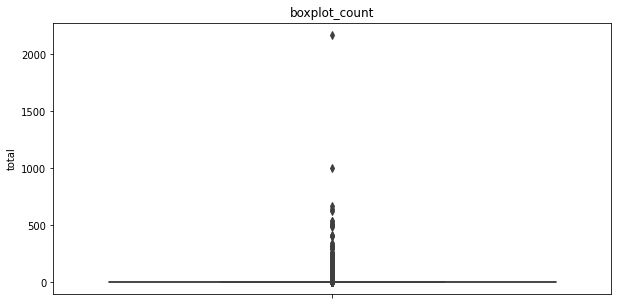

In [ ]:
# Check outliers

fig,(ax1) = plt.subplots(ncols=1)
fig.set_size_inches(10, 5)
sns.boxplot(data=train,y="item_cnt_day",orient="v",ax=ax1) 
ax1.set(ylabel='total',title="boxplot_count")
plt.show()

In [ ]:
# Check outliers for sales (z-score above 3 is consider as outliers)

print("before deleting outliers",train.shape)
df=train[np.abs(train["item_cnt_day"]-train["item_cnt_day"].mean())<=(3*train["item_cnt_day"].std())] 
print("after deleting outliers",df.shape)

before deleting outliers (2928492, 6)
after deleting outliers (2916556, 6)


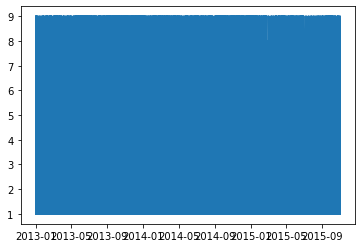

In [ ]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

plt.plot(df["date"], df["item_cnt_day"])

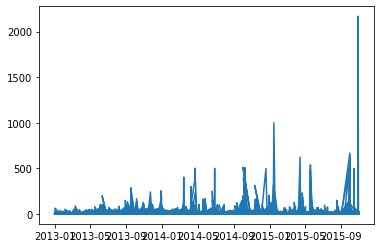

In [ ]:
plt.plot(train["date"], train["item_cnt_day"])

As we can see from the first graph, if we drop the outliers by the outlier calculation formula (drop data that's over 3 standard deviation from the mean), we will end up getting the graph that cannot well represent the overall time series of the dataset. Therefore, we choose to plot the item count by date and drop the largest item count (which is over 2,000) in order to not only keep the time trend of our data, but also increase the accuracy of our dataset for our model analysis.

In [ ]:
train = train[train.item_cnt_day<1001]
train.shape

(2928491, 6)

In [ ]:
# check repeat record
print('shape:', train.shape)
train = train.drop_duplicates()
print('drop duplicate:', train.shape)

shape: (2928491, 6)
drop duplicate: (2928485, 6)


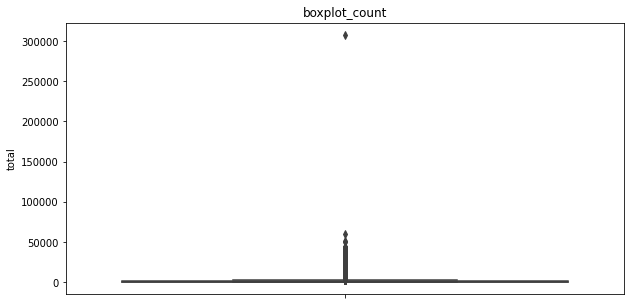

In [ ]:
# Check outliers for price

fig,(ax2) = plt.subplots(ncols=1)
fig.set_size_inches(10, 5)
sns.boxplot(data=train,y="item_price",orient="v",ax=ax2) 
ax2.set(ylabel='total',title="boxplot_count")
plt.show()

In [ ]:
# Drop the price outlier of 300000
train = train[train.item_price<300000]
train.shape

(2928484, 6)

In [ ]:
#Sort
train.sort_values(["date", "date_block_num", "shop_id", "item_id"], inplace=True)

In [ ]:
# Split out city from shop name

shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name"] = 'СергиевПосад ТЦ "7Я"'
shops["shop_city"] = shops.shop_name.str.split(' ').map(lambda x: x[0])
shops["shop_category"] = shops.shop_name.str.split(" ").map(lambda x: x[1])
shops.loc[shops.shop_city == "!Якутск", "shop_city"] = "Якутск" 

In [ ]:
# Encode city

from sklearn.preprocessing import LabelEncoder

shops['city_code'] = LabelEncoder().fit_transform(shops['shop_city'])
shops = shops[['shop_id','city_code',"shop_city"]]

In [ ]:
#Merge columns from other tables
train = train \
    .merge(items, on="item_id", how="left") \
    .merge(item_cat, on="item_category_id", how="left") \
    .merge(shops, on="shop_id", how = "left")

In [ ]:
#Drop unnecessary columns
train = train.drop('item_name', 1)
train = train.drop('item_category_name',1)
train = train.drop('shop_city',1)

In [ ]:
#Aggregate daily sales to monthly sales
train_by_month = train \
    .groupby(["shop_id", "item_id", train["date"].dt.to_period("M").dt.to_timestamp(), "date_block_num","item_category_id","city_code"]) \
    [["item_price", "item_cnt_day"]] \
    .agg({"item_price": [np.mean, np.median], "item_cnt_day": np.sum}) \
    .reset_index()
train_by_month.columns = ["_".join(col[::]).strip("_") for col in train_by_month.columns]
train_by_month.rename({"item_cnt_day_sum": "item_cnt_month"}, axis=1, inplace=True)

In [ ]:
train_by_month["month"] = train_by_month["date"].dt.month
train_by_month["year"] = train_by_month["date"].dt.year
test_data = train_by_month.loc[train_by_month["date_block_num"] == 33]
train_data = train_by_month.loc[train_by_month["date_block_num"] != 33]
test_data

,shop_id,item_id,date,date_block_num,item_category_id,city_code,item_price_mean,item_price_median,item_cnt_month,month,year
8113,2,31,2015-10-01,33,37,0,399.000000,399.000000,1.000000,10,2015
8205,2,486,2015-10-01,33,73,0,300.000000,300.000000,3.000000,10,2015
8254,2,787,2015-10-01,33,49,0,420.000000,420.000000,1.000000,10,2015
8284,2,794,2015-10-01,33,73,0,3300.000000,3300.000000,1.000000,10,2015
8367,2,968,2015-10-01,33,40,0,58.000000,58.000000,1.000000,10,2015
...,...,...,...,...,...,...,...,...,...,...,...
1608099,59,22087,2015-10-01,33,83,30,119.000000,119.000000,6.000000,10,2015
1608131,59,22088,2015-10-01,33,83,30,119.000000,119.000000,2.000000,10,2015
1608148,59,22091,2015-10-01,33,83,30,179.000000,179.000000,1.000000,10,2015
1608174,59,22100,2015-10-01,33,42,30,629.000000,629.000000,1.000000,10,2015


# Exploratory Data Analysis

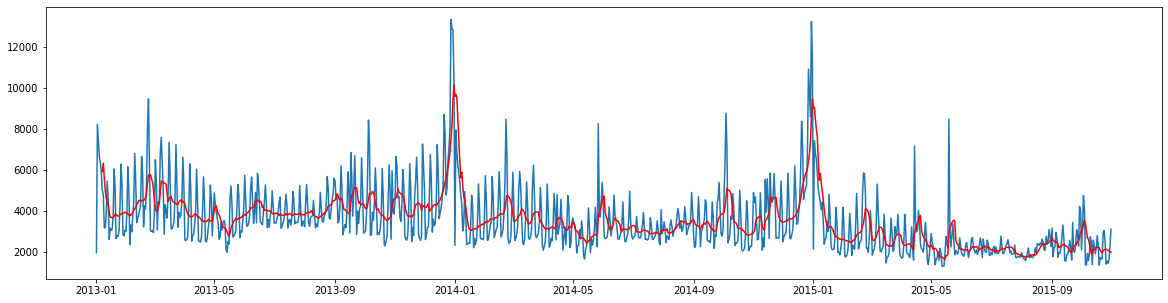

In [ ]:
#figure 3
item_cnt_day_agg = train.groupby("date")["item_cnt_day"].sum()
item_cnt_day_agg_smoothed = item_cnt_day_agg.rolling(window=7).mean()
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(item_cnt_day_agg)
ax.plot(item_cnt_day_agg_smoothed, c="red")

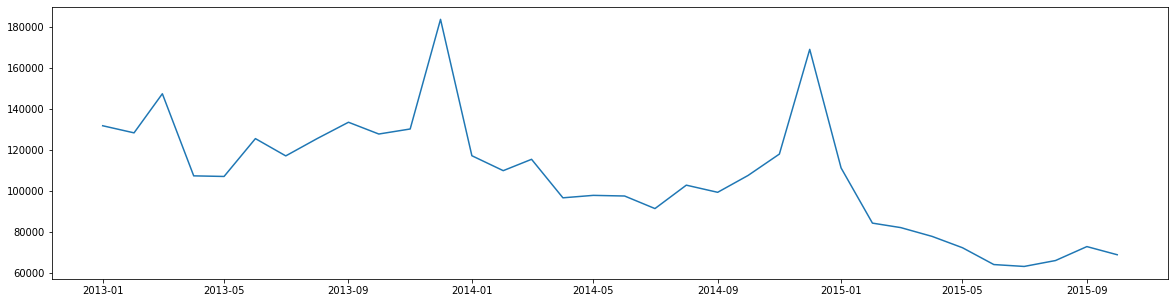

In [ ]:
#figure 4
item_cnt_month_agg = train_by_month.groupby("date")["item_cnt_month"].sum()
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(item_cnt_month_agg)

Figure 3&4 depicts daily sales of all products of the company. We can see that there is obvious seasonality in the sales data, with the highest sales occuring in January.

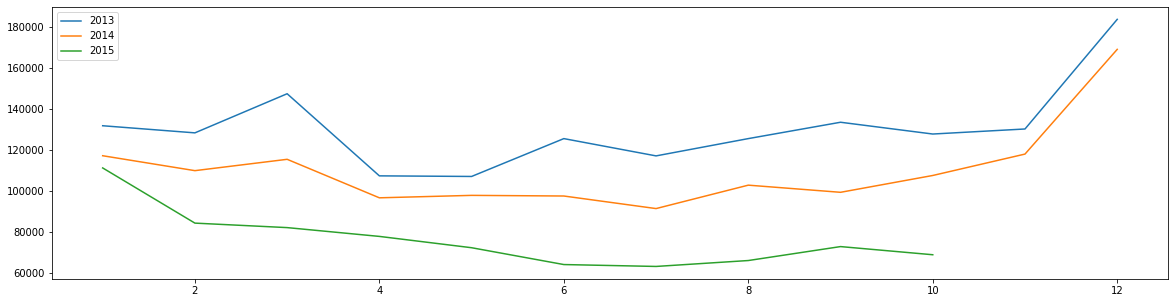

In [ ]:
#figure 5
item_cnt_month_agg = train_by_month.groupby("date")["item_cnt_month"].sum()

item_cnt_month_agg = item_cnt_month_agg.reset_index()
item_cnt_month_agg["year"] = item_cnt_month_agg["date"].dt.year
item_cnt_month_agg["month"] = item_cnt_month_agg["date"].dt.month

fig, ax5 = plt.subplots(figsize=(20, 5))
for year in item_cnt_month_agg["year"].unique():
    ax5.plot(item_cnt_month_agg.loc[item_cnt_month_agg["year"] == year, "month"], item_cnt_month_agg.loc[item_cnt_month_agg["year"] == year, "item_cnt_month"], label=year)
ax5.legend()

Sales decreased year by year. And there is a peak in sales in December each year, that's may be due to Christmas Day in December.

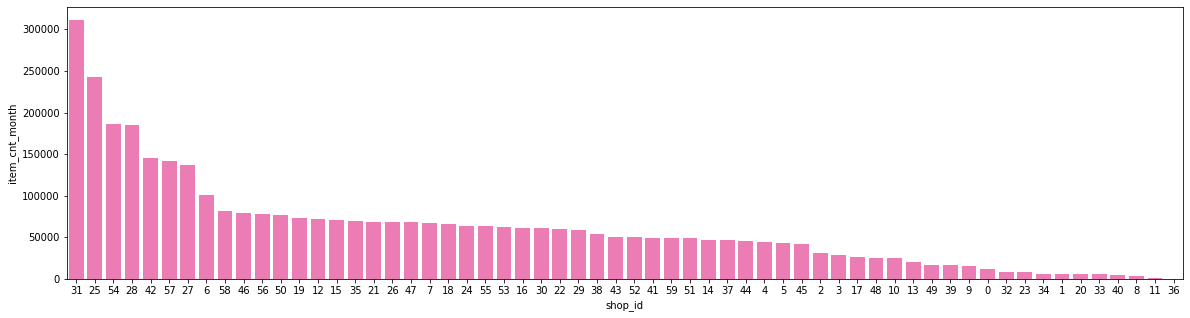

In [ ]:
#figure 6
item_cnt_by_shop_id = train_by_month.groupby("shop_id")["item_cnt_month"].sum().reset_index().sort_values("item_cnt_month", ascending=False)
fig, ax6 = plt.subplots(figsize = (20, 5))
sns.barplot(x="shop_id", y="item_cnt_month", data=item_cnt_by_shop_id, order=item_cnt_by_shop_id["shop_id"], color="hotpink")

Text(0, 0.5, 'Cumulative sum of items sold by shop')

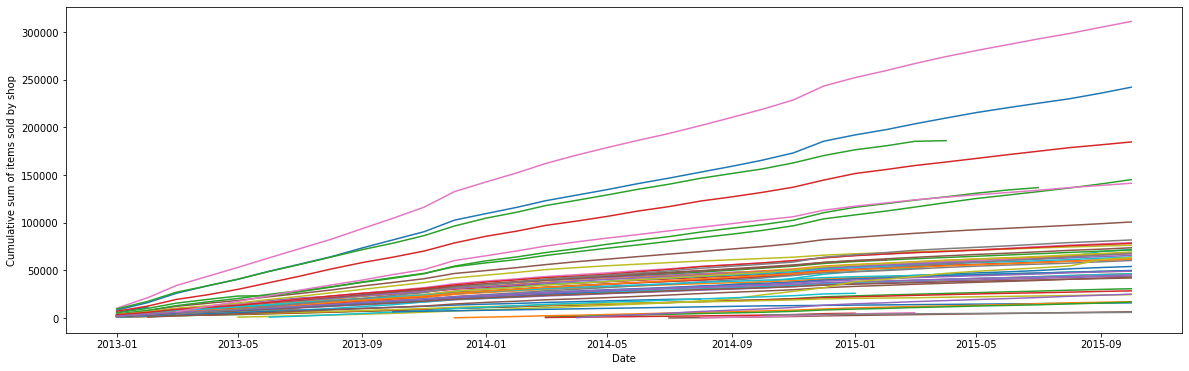

In [ ]:
#figure 7
fig, ax7 = plt.subplots(figsize=(20, 6))
df_shop_cnt_cumsum = train_by_month.groupby(["date", "shop_id"])["item_cnt_month"].sum().groupby("shop_id").cumsum().reset_index()
for i in df_shop_cnt_cumsum["shop_id"].unique():
    ax7.plot(df_shop_cnt_cumsum.loc[df_shop_cnt_cumsum["shop_id"] == i, "date"], 
            df_shop_cnt_cumsum.loc[df_shop_cnt_cumsum["shop_id"] == i, "item_cnt_month"],
            label=i)
ax7.set_xlabel("Date")
ax7.set_ylabel("Cumulative sum of items sold by shop")

As we can see, some shops did not have records at the beginning, and some shops did not have records from the middle. These might be those new shops and closed shops. For these closed shops, their prediction in the test set should be zero.

In [ ]:
# plot sales by city
train_by_city = train \
    .groupby(["city_code"]) \
    .agg({ "item_cnt_day": np.sum}) \
    .reset_index()


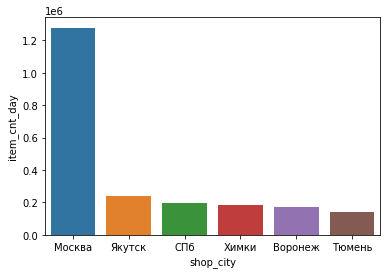

In [ ]:
#Merge columns from other tables

train_by_city = train_by_city \
    .merge(shops, on="city_code", how = "left")

train_by_city=train_by_city[["city_code","item_cnt_day","shop_city"]]
train_by_city = train_by_city.drop_duplicates()
largest6_city= train_by_city.nlargest(6,'item_cnt_day')
ax = sns.barplot(x="shop_city",y='item_cnt_day', data=largest6_city)

In [ ]:
largest6_city

,city_code,item_cnt_day,shop_city
18,13,1278329.000000,Москва
55,29,241348.000000,Якутск
40,19,196017.000000,СПб
52,26,186148.000000,Химки
4,4,171518.000000,Воронеж
47,24,142266.000000,Тюмень


# Modelling

In [ ]:
train_by_month_dummies = pd.get_dummies(train_by_month, columns = ["item_category_id","city_code"])
train_by_month_dummies["item_cnt_month"] = train_by_month_dummies["item_cnt_month"].clip(0,20).astype(np.float16)
test_data_dummy = train_by_month_dummies.loc[train_by_month_dummies["date_block_num"] == 33]
train_data_dummy = train_by_month_dummies.loc[train_by_month_dummies["date_block_num"] != 33]
test_data_dummy

,shop_id,item_id,date,date_block_num,item_price_mean,item_price_median,item_cnt_month,month,year,item_category_id_0,item_category_id_1,item_category_id_2,item_category_id_3,item_category_id_4,item_category_id_5,item_category_id_6,item_category_id_7,item_category_id_8,item_category_id_9,item_category_id_10,item_category_id_11,item_category_id_12,item_category_id_13,item_category_id_14,item_category_id_15,item_category_id_16,item_category_id_17,item_category_id_18,item_category_id_19,item_category_id_20,item_category_id_21,item_category_id_22,item_category_id_23,item_category_id_24,item_category_id_25,item_category_id_26,item_category_id_27,item_category_id_28,item_category_id_29,item_category_id_30,...,item_category_id_75,item_category_id_76,item_category_id_77,item_category_id_78,item_category_id_79,item_category_id_80,item_category_id_81,item_category_id_82,item_category_id_83,city_code_0,city_code_1,city_code_2,city_code_3,city_code_4,city_code_5,city_code_6,city_code_7,city_code_8,city_code_9,city_code_10,city_code_11,city_code_12,city_code_13,city_code_14,city_code_15,city_code_16,city_code_17,city_code_18,city_code_19,city_code_20,city_code_21,city_code_22,city_code_23,city_code_24,city_code_25,city_code_26,city_code_27,city_code_28,city_code_29,city_code_30
8113,2,31,2015-10-01,33,399.000000,399.000000,1.000000,10,2015,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8205,2,486,2015-10-01,33,300.000000,300.000000,3.000000,10,2015,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8254,2,787,2015-10-01,33,420.000000,420.000000,1.000000,10,2015,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8284,2,794,2015-10-01,33,3300.000000,3300.000000,1.000000,10,2015,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8367,2,968,2015-10-01,33,58.000000,58.000000,1.000000,10,2015,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1608099,59,22087,2015-10-01,33,119.000000,119.000000,6.000000,10,2015,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1608131,59,22088,2015-10-01,33,119.000000,119.000000,2.000000,10,2015,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1608148,59,22091,2015-10-01,33,179.000000,179.000000,1.000000,10,2015,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1608174,59,22100,2015-10-01,33,629.000000,629.000000,1.000000,10,2015,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Split data for random forest
train_by_month["item_cnt_month"] = train_by_month["item_cnt_month"].clip(0,20).astype(np.float16)
x_train=train_data.drop(columns=["month","year","date","item_cnt_month"])
y_train=train_data.item_cnt_month
x_test=test_data.drop(columns=["month","year","date","item_cnt_month"])
y_test=test_data.item_cnt_month

# Split data for linear regression (For linear model, converting category and city to dummy variable can increase predict accuracy)
x_train_dummy = train_data_dummy.drop(columns=["month","year","date","item_cnt_month"])
y_train_dummy=train_data_dummy.item_cnt_month
x_test_dummy=test_data_dummy.drop(columns=["month","year","date","item_cnt_month"])
y_test_dummy=test_data_dummy.item_cnt_month


print("x_train ->" , x_train.shape)
print("y_train ->" , y_train.shape)
print("x_test ->" , x_test.shape)
print("y_test ->" , y_test.shape)

x_train -> (1576704, 7)
y_train -> (1576704,)
x_test -> (31521, 7)
y_test -> (31521,)


(array([1038686.,  362652.,   83979.,   34325.,   17712.,   10364.,
           6658.,    4437.,    3271.,    3384.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <a list of 10 Patch objects>)

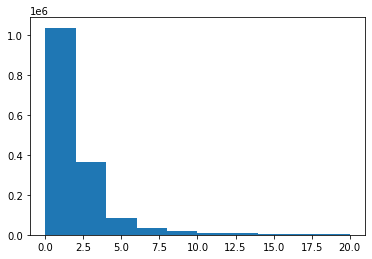

In [ ]:
#y_train.value_counts() #count frequency
#np.log(y_train).value_counts()
plt.hist(y_train, range=(0, 20))


In [ ]:
# Fit a linear regression
import statsmodels.api as sm
first_reg = sm.OLS(y_train_dummy, x_train_dummy).fit()
ols_ypred = first_reg.predict(x_test_dummy).clip(0,20)
#Check RMSE for OLS
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(ols_ypred, y_test_dummy))

print ("RMSE Value For OLS: ",rms)



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


RMSE Value For OLS:  2.3179853506341255


In [ ]:
# Check R^2 for OLS
correlation_matrix = np.corrcoef(ols_ypred, y_test_dummy)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
r_squared 

0.17539455517185437

In [ ]:
# Fit a lasso regression
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
alphas = np.array([0.000001, 0.000003, 0.000007, 0.00001, 0.0001, 0.001])
model_lasso = Lasso(max_iter = 100)
coefs = []
MSE = []
for a in alphas:
    model_lasso.set_params(alpha=a)
    model_lasso.fit(x_train_dummy,y_train_dummy)
    coefs.append(model_lasso.coef_)
    MSE.append(mean_squared_error(y_test_dummy, model_lasso.predict(x_test_dummy)))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.464e+06, tolerance: 1.049e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.465e+06, tolerance: 1.049e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

In [ ]:
# Check RMSE for Lasso
RMSE = np.sqrt(MSE)
RMSE

array([2.316865  , 2.31685388, 2.31683406, 2.3168195 , 2.31631609,
       2.32884726])

Since the fifth parameter (0.0001) has the lowest RMSE, we choose it as our final tuning parameter, which gives us a RMSE of 2.3168

In [ ]:
# Fit a Random Forest
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor()
rfModel.fit(x_train,y_train)
rf_preds = rfModel.predict(X= x_test).clip(0,20)

from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(rf_preds, y_test))
print ("RMSE Value For Random Forest: ",rms)

RMSE Value For Random Forest:  6.665732083138455


# Machine Learning

In [ ]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [ ]:
# check repeat record
print('shape:', test.shape)
print('drop duplicate:', test.drop_duplicates().shape)

shape: (214200, 3)
drop duplicate: (214200, 3)


In [ ]:
# Add date_block_num to test date
test["date_block_num"]=34

In [ ]:
#Merge columns from other tables
test = test \
    .merge(items, on="item_id", how="left") \
    .merge(item_cat, on="item_category_id", how="left") \
    .merge(shops, on="shop_id", how = "left")

test=test.drop(columns=["item_name","item_category_name","ID"])
test.head()

,shop_id,item_id,date_block_num,item_category_id,city_code,shop_city
0,5,5037,34,19,3,Вологда
1,5,5320,34,55,3,Вологда
2,5,5233,34,19,3,Вологда
3,5,5232,34,23,3,Вологда
4,5,5268,34,20,3,Вологда


In [ ]:
# find category id in train not in test

tecatlist=list(set(test.item_category_id))
trcatlist=list(set(train.item_category_id))

catlist=[]
for i in range(len(trcatlist)):
    if trcatlist[i] not in tecatlist:
        catlist.append (trcatlist[i])
print(catlist)

[1, 4, 8, 10, 13, 14, 17, 18, 32, 39, 46, 48, 50, 51, 52, 53, 59, 66, 68, 80, 81, 82]


In [ ]:
# find city code in train not in test

tecitylist=list(set(test.city_code))
trcitylist=list(set(train.city_code))

citylist=[]
for i in range(len(trcitylist)):
    if trcitylist[i] not in tecitylist:
        citylist.append (trcitylist[i])
print(citylist)

[5, 14, 26]


In [ ]:
# Convert category id and city code to dummies
test_by_month_dummies = pd.get_dummies(test, columns = ["item_category_id","city_code"])

In [ ]:
# Add features (test do not have but train have) and set value to zero

test_by_month_dummies = pd.concat([test_by_month_dummies, pd.DataFrame(columns = [ str('item_category_id_' + str(catlist[i])) for i in range(len(catlist)) ])])
test_by_month_dummies=pd.concat([test_by_month_dummies, pd.DataFrame(columns = [ str('city_code_' + str(citylist[i])) for i in range(len(citylist)) ])])

test_by_month_dummies=test_by_month_dummies.fillna(0)

In [ ]:
# Add mean price and median price to test data

train_use =train_by_month[['shop_id', 'item_id', 'item_price_mean', 'item_price_median', "date_block_num"]]
train_use = train_use[train_use["date_block_num"]==33]

test_by_month_dummies_2 = pd.merge(test_by_month_dummies,train_use, on = ["shop_id", "item_id"], how = "left")

test_by_month_dummies_2=test_by_month_dummies_2.fillna(0)
test_by_month_dummies_2.shape

In [ ]:
test_by_month_dummies_2=test_by_month_dummies_2.drop(columns=["date_block_num_y"])

In [ ]:
# fit Lasso model with best alpha

model_lasso2 = Lasso(max_iter = 100)

model_lasso2.set_params(alpha=0.0001)
model_lasso2.fit(x_train_dummy,y_train_dummy)

In [ ]:
# Make prediction

test_data_X=test_by_month_dummies_2

sales_pred=model_lasso2.predict(test_data_X).clip(0,20)

In [ ]:
# Output predictions

sample.loc[:, 'item_cnt_month'] = sales_pred
sample.to_csv('submission.csv', index=False)